# Problem Description
The goal of this project is to predict whether a given tweet is about a real disaster or not.

# Data
- id: a unique identifier for each tweet
- text: the text of the tweet
- location: the location the tweet was sent from (may be blank)
- keyword: a particular keyword from the tweet (may be blank)
- target: in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

# Project Setup

In [26]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')       

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Exploratory Data Analysis
- Basic structure and initial inspection
- Missing values count
- Target distribution
- Word count distribution

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Missing Values:
           Count  Perce

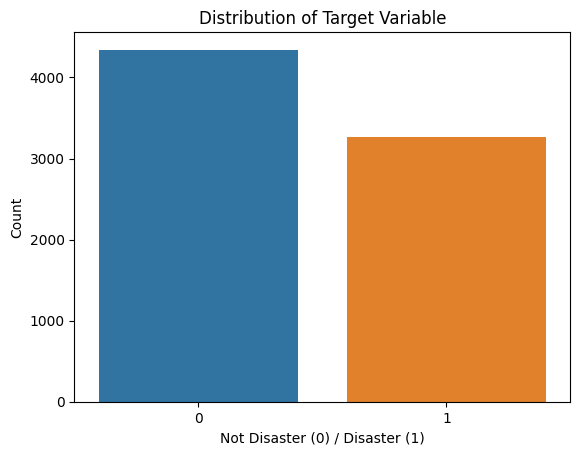

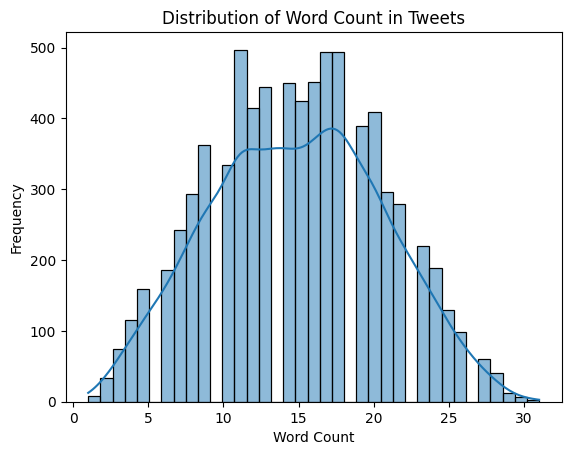

In [27]:
train_data.info()
print('')
print(train_data.head())

missing_values = train_data.isnull().sum()
missing_percentage = (missing_values / len(train_data)) * 100
print("\nMissing Values:\n", pd.DataFrame({"Count": missing_values, "Percentage": missing_percentage}))

sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.xlabel('Not Disaster (0) / Disaster (1)')
plt.ylabel('Count')
plt.show()

train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))
sns.histplot(train_data['word_count'], kde=True)
plt.title('Distribution of Word Count in Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Preprocessing
- Separate features and labels
- Initialize parameters
- Initialize and fit the tokenizer
- Sequence text
- Pad sequences
- Split data

In [28]:
X = train_data['text'].values
y = train_data['target'].values

vocab_size = 10000
embedding_dim = 64

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

X_sequences = tokenizer.texts_to_sequences(X)

X_padded = pad_sequences(X_sequences, padding='post')

X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Analysis
- Model structure and compilation
- Instantiate callbacks
- Train the model

In [29]:
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3,  
    restore_best_weights=True 
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',  
    monitor='val_loss',
    save_best_only=True,  
    mode='min' 
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=2,
    callbacks=[early_stopping, model_checkpoint]
)

print('Training Complete')

Epoch 1/10
96/96 - 9s - 89ms/step - accuracy: 0.5846 - loss: 0.6684 - val_accuracy: 0.7597 - val_loss: 0.5390
Epoch 2/10
96/96 - 5s - 52ms/step - accuracy: 0.7901 - loss: 0.5005 - val_accuracy: 0.7971 - val_loss: 0.4515
Epoch 3/10
96/96 - 5s - 55ms/step - accuracy: 0.8713 - loss: 0.3604 - val_accuracy: 0.8214 - val_loss: 0.4604
Epoch 4/10
96/96 - 5s - 51ms/step - accuracy: 0.9010 - loss: 0.3038 - val_accuracy: 0.8096 - val_loss: 0.4834
Epoch 5/10
96/96 - 5s - 52ms/step - accuracy: 0.9250 - loss: 0.2488 - val_accuracy: 0.7945 - val_loss: 0.5549
Epoch 6/10
96/96 - 5s - 52ms/step - accuracy: 0.9356 - loss: 0.2180 - val_accuracy: 0.7938 - val_loss: 0.6379
Training Complete


# Result

In [30]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy:.2f}')

y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred, zero_division=1))



48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8014 - loss: 0.4890
Validation Accuracy: 0.82
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       874
           1       0.84      0.71      0.77       649

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



# Conclusion
The model had generally good performance. The model identifies negative cases correctly. The model generally did well with the postitives but missed more than the negative class.

# Submission

In [31]:
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
X_test = test_data['text'].values

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, padding='post')

predictions = (model.predict(X_test_padded) > 0.5).astype("int32")

submission = pd.DataFrame({
    'id': test_data['id'],
    'target': predictions.flatten()
})

submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
